## Imports

In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from dataset import LEVIRCDDataset
from utils import *
from model import *
from train import *
# import wandb
# import random

# wandb.init(project="levircd_getting_started")

## Data Path

In [2]:
#train data
image_dir_A_train = '../data/lesson_1/train/A/'
image_dir_B_train = '../data/lesson_1/train/B/'
label_dir_train = '../data/lesson_1/train/label/'

#validation data
image_dir_A_val = '../data/lesson_1/val/A/'
image_dir_B_val = '../data/lesson_1/val/B/'
label_dir_val = '../data/lesson_1/val/label/'

#test data
image_dir_A_test = '../data/lesson_1/test/A/'
image_dir_B_test = '../data/lesson_1/test/B/'
label_dir_test = '../data/lesson_1/test/label/'


## Augmentation

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

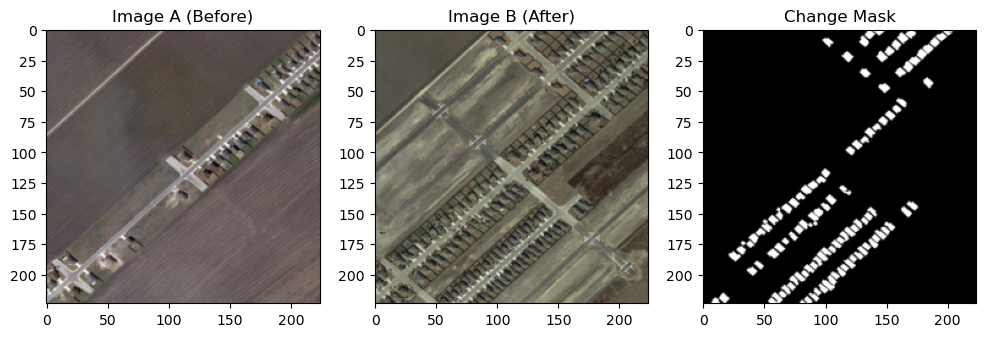

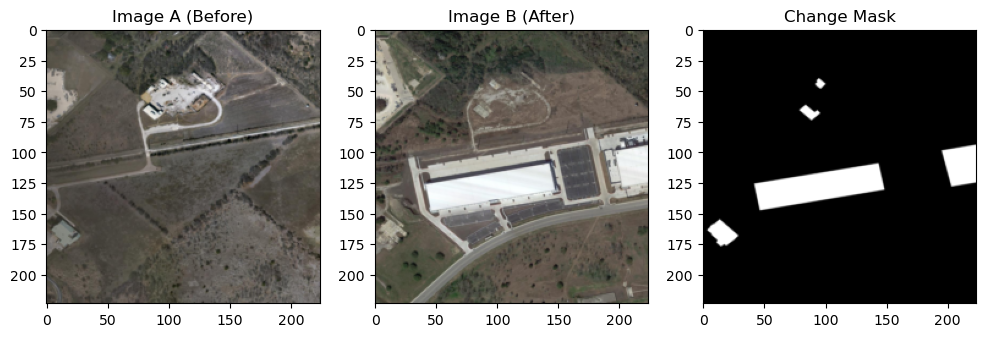

In [4]:
levir_cd_dataset_train = LEVIRCDDataset(image_dir_A_train, image_dir_B_train, label_dir_train, transform=transform)
traindataloader = DataLoader(levir_cd_dataset_train, batch_size=8, shuffle=True)
(image_A, image_B), label = next(iter(traindataloader))
show_images(image_A[0], image_B[0], label[0])
show_images(image_A[1], image_B[1], label[1])

## Model

In [5]:
model = UNet(in_channels=6, out_channels=1)
model.to(device); 

## Loss function and Optimizer

In [6]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

## Training

In [7]:
levir_cd_dataset_train = LEVIRCDDataset(image_dir_A_train, image_dir_B_train, label_dir_train, transform=transform)
levir_cd_dataset_val = LEVIRCDDataset(image_dir_A_val, image_dir_B_val, label_dir_val, transform=transform)
levir_cd_dataset_test = LEVIRCDDataset(image_dir_A_test, image_dir_B_test, label_dir_test, transform=transform)

# DataLoader
train_loader = DataLoader(levir_cd_dataset_train, batch_size=32, shuffle=True, num_workers=4, persistent_workers=True)
validate_loader = DataLoader(levir_cd_dataset_val, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(levir_cd_dataset_test, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)


In [ ]:
train_losses, train_ious, train_dices, val_losses, val_ious, val_dices = train_model(model, criterion, optimizer,scheduler,train_loader, 
                                                                                     validate_loader, num_epochs=100, save_name='unet_levir_cd_baseline')

## Training and Validation set Performance

In [8]:
#put it in utils
def remove_outliers(data, m=2):
    return np.array(data)[abs(data - np.mean(data)) < m * np.std(data)]

In [9]:
metrics = torch.load("../model_weights/1726353735/unet_levir_cd_baseline_1726353735_metrics.pth")

In [10]:
train_losses = remove_outliers(metrics['train_losses'])
train_ious = remove_outliers(metrics['train_ious'])
train_dices = remove_outliers(metrics['train_dices'])
val_losses = remove_outliers(metrics['val_losses'])
val_ious = remove_outliers(metrics['val_ious'])
val_dices = remove_outliers(metrics['val_dices'])


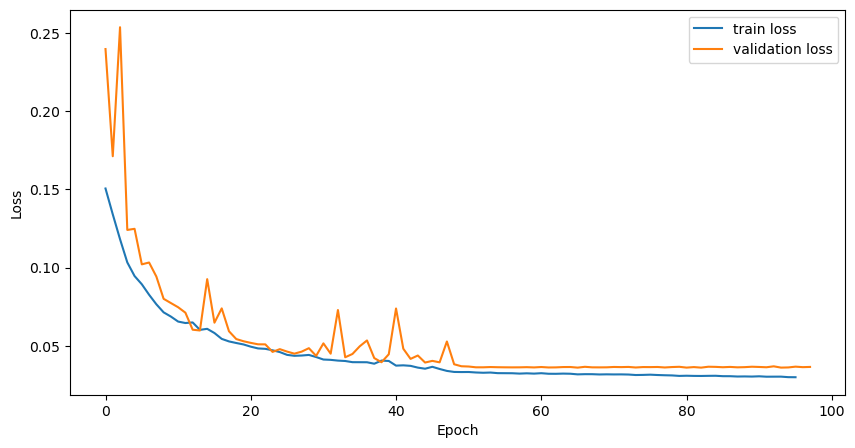

In [11]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

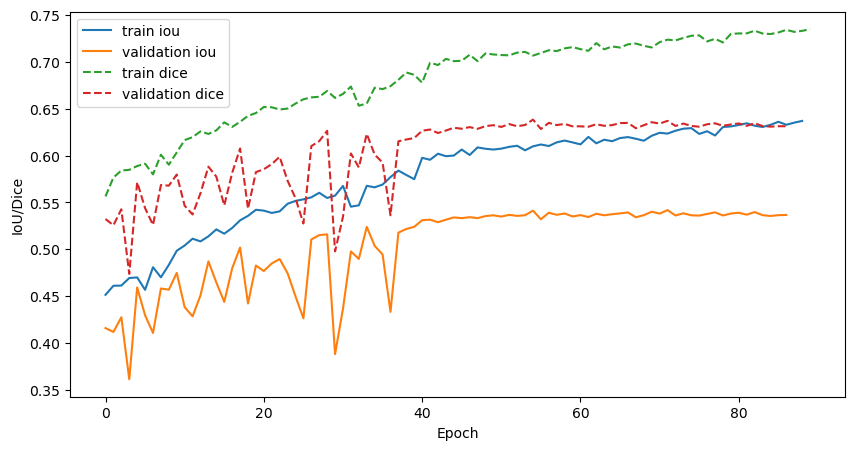

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(remove_outliers(train_ious), label='train iou')
plt.plot(remove_outliers(val_ious), label='validation iou')
plt.plot(remove_outliers(train_dices), label='train dice', linestyle='dashed')
plt.plot(remove_outliers(val_dices), label='validation dice', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('IoU/Dice')
plt.legend()

## Performance on test data

In [13]:
del model  
del optimizer  
del criterion  

# Clear the cache
torch.cuda.empty_cache()

In [14]:
model = UNet(in_channels=6, out_channels=1).to(device)
test_loader = DataLoader(levir_cd_dataset_test, batch_size=32, shuffle=False, num_workers=4, persistent_workers=True)
model.load_state_dict(torch.load('../model_weights/1726353735/unet_levir_cd_baseline_1726353735_best.pth'))
criterion = nn.BCELoss()
epoch_loss, mean_iou, mean_dice = validate_model(model, test_loader, criterion)
print(f'Loss: {epoch_loss:.4f}, IoU: {mean_iou:.4f}, DICE: {mean_dice:.4f}')

Loss: 0.0447, IoU: 0.5668, DICE: 0.6721


## Visualization

In [16]:
# visualize_test_results(model, test_loader, num_examples=2)

In [ ]:
## selcting the best 5 images and ploting
dice_scores = []
iou_scores = []
test_loader = DataLoader(levir_cd_dataset_test, batch_size=1, shuffle=False, num_workers=4, persistent_workers=True)

for i, ((image_A, image_B), labels) in enumerate(test_loader):
    model.eval()
    with torch.no_grad(): 
        image_A, image_B, labels = image_A.to(device), image_B.to(device), labels.to(device)
        inputs = torch.cat([image_A, image_B], dim=1)
        outputs = model(inputs)
        outputs = (outputs > 0.5).float()
        dice_score = compute_dice(outputs, labels).item()
        iou_score = compute_iou(outputs, labels).item()
        dice_scores.append(dice_score)
        iou_scores.append(iou_score)
        # plot the images with the highest dice score
        if dice_score > 0.88:
            show_images(image_A[0].cpu(), image_B[0].cpu(), labels[0].cpu(), outputs[0].cpu())

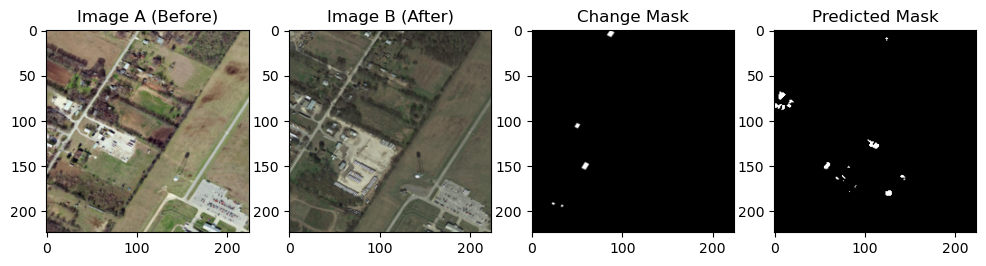

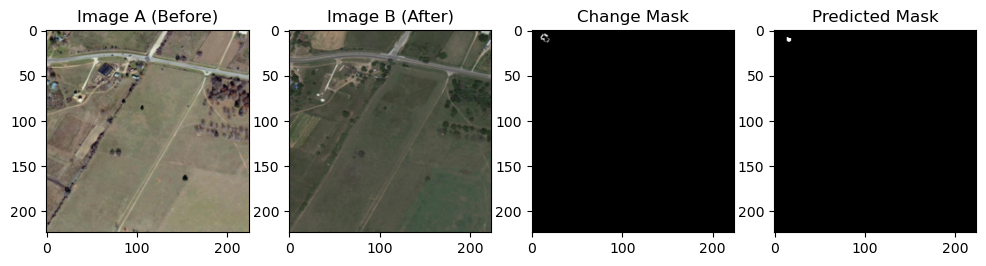

In [22]:
## selcting the best 5 images and ploting
dice_scores = []
iou_scores = []
test_loader = DataLoader(levir_cd_dataset_test, batch_size=1, shuffle=False, num_workers=4, persistent_workers=True)

for i, ((image_A, image_B), labels) in enumerate(test_loader):
    model.eval()
    with torch.no_grad(): 
        image_A, image_B, labels = image_A.to(device), image_B.to(device), labels.to(device)
        inputs = torch.cat([image_A, image_B], dim=1)
        outputs = model(inputs)
        outputs = (outputs > 0.5).float()
        dice_score = compute_dice(outputs, labels).item()
        iou_score = compute_iou(outputs, labels).item()
        dice_scores.append(dice_score)
        iou_scores.append(iou_score)
        # plot the images with the highest dice score
        if dice_score < 0.2 and dice_score != 0:
            show_images(image_A[0].cpu(), image_B[0].cpu(), labels[0].cpu(), outputs[0].cpu())